# import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

# spatial weights
from libpysal.weights import KNN, DistanceBand, lag_spatial

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# import matplotlib.lines as mlines
import matplotlib.colors as mcolors

from libpysal.weights import KNN, DistanceBand
from libpysal.cg import KDTree

/home/liaom/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-b16d6be86306>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (cal

# Data Input

In [2]:
# read survey data
care_df = pd.read_csv('caresurveydata_Oshan_012524.csv')

In [3]:
# read census tracts in DC
dc_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_11_tract.zip")
care_gdf = gpd.GeoDataFrame(care_df.copy(), geometry=gpd.points_from_xy(care_df.lon_new, care_df.lat_new), crs = dc_census_tract.crs)

# Reproject the D.C. boundary data to the projected coordinate system "MD State Plane NAD 83"
care_gdf_rprj = care_gdf.to_crs("EPSG:6487")
dc_census_tract_rprj = dc_census_tract.to_crs("EPSG:6487")

In [4]:
care_df.columns

Index(['pseudoid', 'respond_type', 'surv_lang', 'lon_new', 'lat_new', 'WARD',
       'TRACT_new', 'GEOID_new', 'BLKGRP_new', 'FIPS.Code', 'Block', 'age',
       'gender', 'SES_ladder_NH', 'cohes_avg', 'ERI_res_expl_total',
       'race_eth_category_a', 'income_a', 'marital_a', 'education_a',
       'life_satisfaction_1_a', 'SES_ladder_USA_a', 'materialhardship_tot_a',
       'place_attachment_avg_a', 'ISC_avg_a', 'NH_CE_avg_a',
       'NH_safety_avg_a'],
      dtype='object')

# Geographically Weighted Correlation Coefficients

In [5]:
# Function to calculate GWCC using provided weights and indices

def calculate_gwcc(corr_gdf, w, var1, var2):
    
    # Standardize the two variables
    zvar1 = (corr_gdf[var1] - corr_gdf[var1].mean()) / corr_gdf[var1].std()
    zvar2 = (corr_gdf[var2] - corr_gdf[var2].mean()) / corr_gdf[var2].std()

    # Create a dataframe to store GWCC values for each location
    gwcc_results = pd.DataFrame(index=corr_gdf.index, columns=['GWCC'])

    # Calculate GWCC for each location
    for i in corr_gdf.index:
        neighbors = w.neighbors[i]
        weights = np.array(w.weights[i])

        local_var1 = zvar1.iloc[neighbors]
        local_var2 = zvar2.iloc[neighbors]

        # Calculate the weighted correlation coefficient
        weighted_covariance = np.sum(weights * (local_var1 - local_var1.mean()) * (local_var2 - local_var2.mean())) / np.sum(weights)

        weighted_var1 = np.sum(weights * (local_var1 - local_var1.mean())**2) / np.sum(weights)
        weighted_var2 = np.sum(weights * (local_var2 - local_var2.mean())**2) / np.sum(weights)

        gwcc = weighted_covariance / np.sqrt(weighted_var1 * weighted_var2)

        # Store the result
        gwcc_results.loc[i, 'GWCC'] = gwcc
        
    return gwcc_results



In [6]:
# Remove nan values
care_gdf_rprj_nonan = care_gdf_rprj.copy()
care_gdf_rprj_nonan = care_gdf_rprj_nonan[~care_gdf_rprj_nonan.NH_safety_avg_a.isna()]
care_gdf_rprj_nonan = care_gdf_rprj_nonan[~care_gdf_rprj_nonan.place_attachment_avg_a.isna()]
corr_gdf = care_gdf_rprj_nonan.reset_index().copy()

In [7]:
# Create spatial weights with k = 50
coords = np.array([(point.x, point.y) for point in corr_gdf.geometry])
kd_tree = KDTree(coords)
w = KNN(kd_tree, 50)

# Calculate GWCC using `calculate_gwcc()` function
gwcc_results = calculate_gwcc(corr_gdf, w, 'NH_safety_avg_a', 'place_attachment_avg_a')
corr_gdf = corr_gdf.join(gwcc_results)

/home/liaom/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


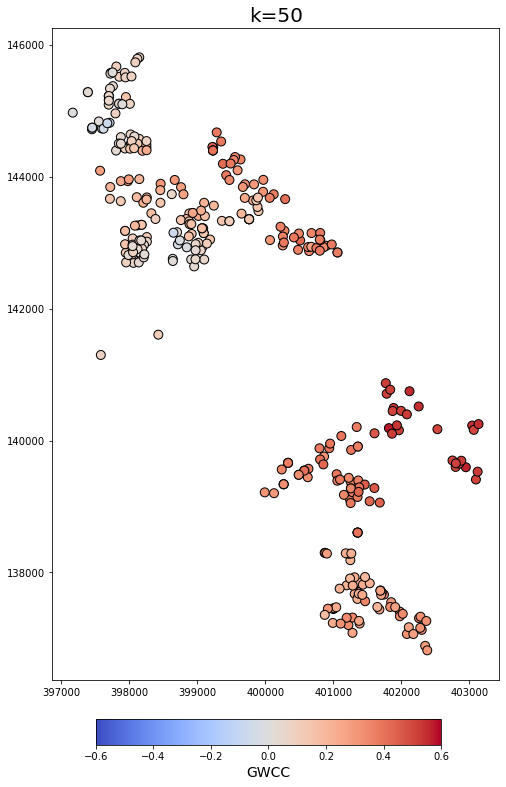

In [8]:
# Extract x and y from geometry for plotting
x = corr_gdf.geometry.x
y = corr_gdf.geometry.y
values = corr_gdf['GWCC']

# Initialize the figure 
fig, ax = plt.subplots(1, 1, figsize=(8, 12))

# Normalize the colorbar from -1 to 1
norm = mcolors.Normalize(vmin= -1 * round(np.max(values), 1), vmax=round(np.max(values), 1))

# Create a scatter plot
sc = ax.scatter(x, y, c=values, cmap='coolwarm', edgecolor='black', norm=norm, s=80)

# Set title 
ax.set_title(f'k=50', fontsize=20)

# Create colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03]) # [x-pos, y-pos, width, height] relative to figure size 
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label('GWCC', size = 14)
cbar.set_ticks(np.linspace(-1, 1, 11))  # Setting ticks for the color bar

# Save plot
# plt.savefig('results/gwcc_safety_place_attachement_k_values.png', dpi=300, bbox_inches='tight')
plt.show()

/home/liaom/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
<ipython-input-9-33582c89293a>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


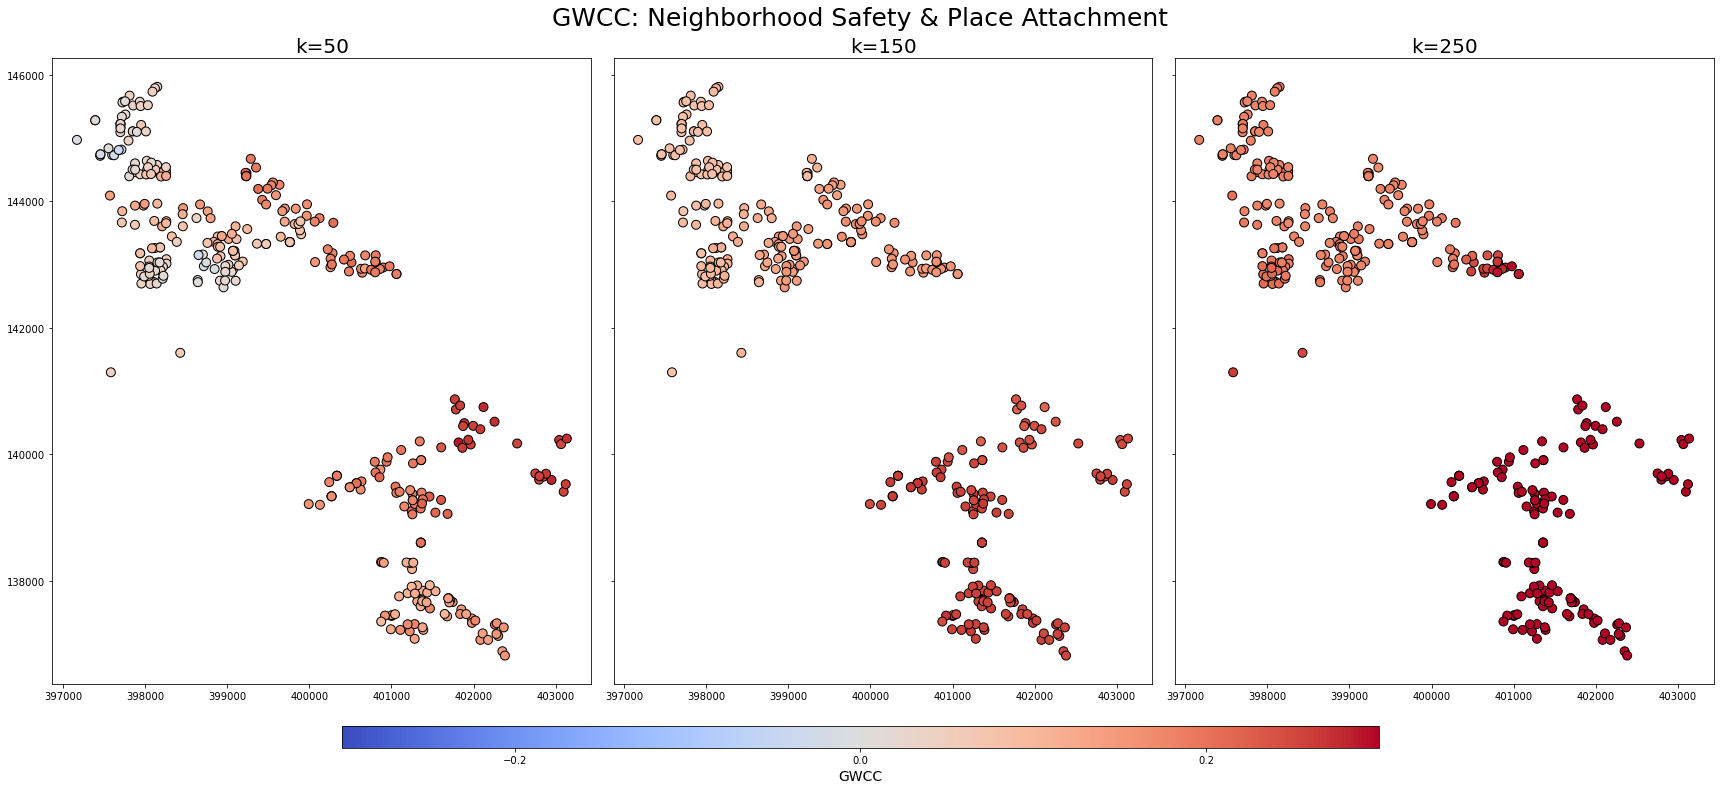

In [9]:
# Initialize the figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)
fig.suptitle('GWCC: Neighborhood Safety & Place Attachment', fontsize=25)

# Normalize the colorbar from -1 to 1
norm = mcolors.Normalize(vmin=-1, vmax=1)

# List of k values
k_values = [50, 150, 250]

for ax, k in zip(axes.flatten(), k_values):
    
    # Calculate GWCC with the current k
    kd_tree = KDTree(coords)
    w = KNN(kd_tree, k)
    corr_gdf = care_gdf_rprj_nonan.reset_index().copy()
    gwcc_results = calculate_gwcc(corr_gdf, w, 'NH_safety_avg_a', 'place_attachment_avg_a')
    corr_gdf = corr_gdf.join(gwcc_results)

    # Extract x and y from geometry for plotting
    x = corr_gdf.geometry.x
    y = corr_gdf.geometry.y
    values = corr_gdf['GWCC']
    
    # Normalize the colorbar from -1 to 1
    norm = mcolors.Normalize(vmin= -1 * round(np.max(values), 1), vmax=round(np.max(values), 1))

    # Create a scatter plot on the current subplot axis
    sc = ax.scatter(x, y, c=values, cmap='coolwarm', edgecolor='black', norm=norm, s=80)

    # Title for the subplot
    ax.set_title(f'k={k}', fontsize=20)

cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.03]) 
# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label('GWCC', size = 14)
cbar.set_ticks(np.linspace(-1, 1, 11))  # Setting ticks for the color bar
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()
#plt.savefig('results/gwcc_safety_place_attachement_k_values.png', dpi=300, bbox_inches='tight')
plt.show()
